# Intro

**The goals here are:**

1. Repeat the best NLP procedure onto the descriptions.
2. Join resulting components with the latest components for titles (`train_nlp_features4.pkl`)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
import cyrtranslit
from sklearn import preprocessing, model_selection, metrics, feature_selection, ensemble, linear_model, cross_decomposition, feature_extraction, decomposition
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import time
color = sns.color_palette()

%matplotlib inline

In [4]:
train = pd.read_pickle('../../train.pkl',compression='zip')

test = pd.read_pickle('../../test.pkl',compression='zip')

In [3]:
ru_stop = nltk.corpus.stopwords.words('russian')

# NLP on Descriptions

The best procedure so far was:
>Create PLSR components from a large CSR term-frequency matrix using unigrams, stopwords and `lowercase=False` using a batch process. `Min_df` could be lowered further to allow more features in, at the expense of longer waiting times. Then repeat the same for bigrams, join with previous and PLSR-reduce to 10 components.

Here I'll see how that works on descriptions. 

In [5]:
vec = feature_extraction.text.TfidfVectorizer(
    stop_words=ru_stop,
    lowercase=False,
    #max_features=8600,
    #ngram_range=(1,2),
    min_df=0.00005,
    #max_df=0.0005
)
# Fitting on train and test as merged lists
vec.fit(train['description'].astype(str).tolist() + test['description'].astype(str).tolist())
print(len(vec.get_feature_names()))

33745


- Had to tweak `min_df` by reducing a zero in order to get 33k features, which is close to the n_features for titles. Otherwise n_features would be 130k, which would take hours to decompose.

In [6]:
# Word counts for train. CSR Matrix, tokens ordered alphabetically
counts = vec.transform(train['description'].astype(str).tolist())

In [7]:
counts.shape

(1503424, 33745)

In [8]:
# Reduce all CSR values in batches
t = time.time()
reduced = pd.DataFrame(index=train.index)
low_col = 0
# Start iteration with columns
for col in np.arange(0,int(counts.shape[1]*1.05),2000):
    # Limiting the edge case of the last values
    if col > counts.shape[1]:
        col = counts.shape[1]
    up_col = col
    
    if up_col > low_col:
        # Train PLSR on a large sample of those columns from CSR
        print('CSR Columns:',low_col,up_col)
        index = np.random.choice(len(train),size=int(4e5))
        sample = counts[index,low_col:up_col].toarray()
        reduce = cross_decomposition.PLSRegression(n_components=5)
        reduce.fit(sample,train.iloc[index].deal_probability)
        print('Score for feature range:',reduce.score(sample,train.iloc[index].deal_probability))
        
        # Nested indexes iteration
        components = pd.DataFrame()
        low_idx = 0
        for idx in np.arange(0,int(len(train)*1.1),int(3.1e5)):
            # Limiting the edge case of the last values
            if idx > len(train):
                idx = len(train)
            up_idx = idx

            if up_idx > low_idx:
                #print('Indexes:',low_idx,up_idx,'Columns:',low_col,up_col)
                sample = counts[low_idx:up_idx,low_col:up_col].toarray()
                #print('Sample shape:',sample.shape)
                sample = reduce.transform(sample)
                components = components.append(pd.DataFrame(sample))
                low_idx = idx
        components.reset_index(drop=True,inplace=True)
        components.columns = ['col_{}-{}_{}'.format(low_col,up_col,i) for i in range(0,5)]
        reduced = reduced.join(components)
        print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced,y=train.deal_probability))
        print('Aggregate shape:',reduced.shape,'\n')
        low_col = col
print('Minutes:',(time.time()-t)/60)

CSR Columns: 0 2000
Score for feature range: 0.025844996966624456
Aggregate score: [0.01806055 0.01737924 0.01710731 0.01836302]
Aggregate shape: (1503424, 5) 

CSR Columns: 2000 4000
Score for feature range: 0.02836370804628041
Aggregate score: [0.03493937 0.03367467 0.03419993 0.03550503]
Aggregate shape: (1503424, 10) 

CSR Columns: 4000 6000
Score for feature range: 0.03706447946158187
Aggregate score: [0.05577483 0.05352489 0.05497558 0.05597051]
Aggregate shape: (1503424, 15) 

CSR Columns: 6000 8000
Score for feature range: 0.04099345269365351
Aggregate score: [0.07456628 0.07136127 0.0735364  0.07357609]
Aggregate shape: (1503424, 20) 

CSR Columns: 8000 10000
Score for feature range: 0.05111591503029023
Aggregate score: [0.09269793 0.08938168 0.09107422 0.09215384]
Aggregate shape: (1503424, 25) 

CSR Columns: 10000 12000
Score for feature range: 0.039953931348558736
Aggregate score: [0.10296699 0.09923814 0.10038493 0.10230855]
Aggregate shape: (1503424, 30) 

CSR Columns: 12

**Observations**

- Column ranges seem to add much more value individually compared to all similar iterations I've done using titles.
- Aggregate scores have climbed here much faster than with titles. By the fourth iteration, these scores are already at 7%.
- By the last iterations, the score increate slowed down significantly.
- Ended at a lesser score than the titles, but very close.

**Explanations**

- **Narrowing `min_df` limited the amount of data in descriptions allowed to pass into PLSR.** While it is the same absolute amount of data than that used with titles, since descriptions contain more tokens than titles they would need larger matrices to convey all their potential predictive value. This is an architectural bottleneck, since Im only willing to use 34k terms and wait 21 minutes at this point in time. 

In [9]:
reduced.shape

(1503424, 85)

reduced.to_pickle('train_nlp_features5.pkl',compression='zip')

In [11]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced,y=train.deal_probability))

Aggregate score: [0.16140165 0.15721052 0.16054215 0.16103708]


## Second Round of Decomposition

In [13]:
reduce = cross_decomposition.PLSRegression(n_components=10)
reduce.fit(reduced,train.deal_probability)
print(reduce.score(reduced,train.deal_probability))

0.16016258433610697


In [14]:
reduced2 = reduce.transform(reduced)

In [15]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced2,y=train.deal_probability))

Aggregate score: [0.16149489 0.1572853  0.16064484 0.16115773]


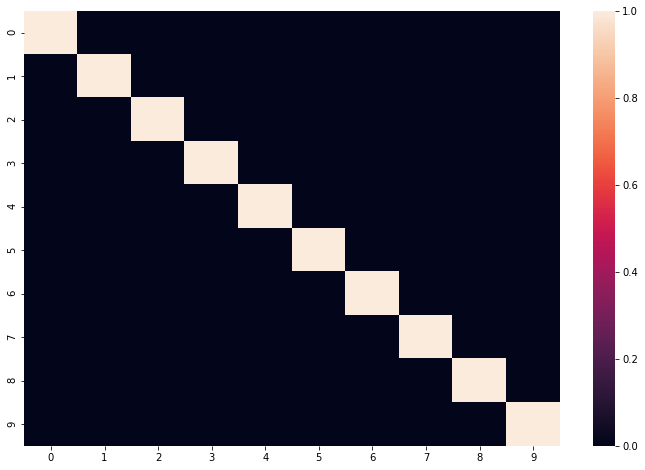

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(reduced2).corr())
plt.show()

In [21]:
reduced2 = pd.DataFrame(reduced2,columns=['desc_{}'.format(i) for i in range(0,10)])

reduced2.to_pickle('train_nlp_features5.pkl',compression='zip')

# BiGrams on Descriptions

- Hopefully combining this with bigrams from the same descriptions will increase the score a little bit.

In [4]:
vec = feature_extraction.text.TfidfVectorizer(
    stop_words=ru_stop,
    lowercase=False,
    #max_features=8600,
    ngram_range=(2,2),
    min_df=0.00005,
    #max_df=0.0005
)
# Fitting on train and test as merged lists
vec.fit(train['description'].astype(str).tolist() + test['description'].astype(str).tolist())
print(len(vec.get_feature_names()))

30982


In [5]:
# Word counts for train. CSR Matrix, tokens ordered alphabetically
counts = vec.transform(train['description'].astype(str).tolist())

In [6]:
counts.shape

(1503424, 30982)

- **Memory kept crashing here.** So I lowered the column range from 2k to 1.5k per iteration. This will produce more iterations and take longer, but that's better than reducing sample size to train which would increase overfitting.

In [6]:
# Reduce all CSR values in batches
t = time.time()
reduced = pd.DataFrame(index=train.index)
low_col = 0
# Start iteration with columns
for col in np.arange(0,int(counts.shape[1]*1.05),1500):
    # Limiting the edge case of the last values
    if col > counts.shape[1]:
        col = counts.shape[1]
    up_col = col
    
    if up_col > low_col:
        # Train PLSR on a large sample of those columns from CSR
        print('CSR Columns:',low_col,up_col)
        index = np.random.choice(len(train),size=int(4e5))
        sample = counts[index,low_col:up_col].toarray()
        reduce = cross_decomposition.PLSRegression(n_components=5)
        reduce.fit(sample,train.iloc[index].deal_probability)
        print('Score for feature range:',reduce.score(sample,train.iloc[index].deal_probability))
        
        # Nested indexes iteration
        components = pd.DataFrame()
        low_idx = 0
        for idx in np.arange(0,int(len(train)*1.1),int(3.1e5)):
            # Limiting the edge case of the last values
            if idx > len(train):
                idx = len(train)
            up_idx = idx

            if up_idx > low_idx:
                #print('Indexes:',low_idx,up_idx,'Columns:',low_col,up_col)
                sample = counts[low_idx:up_idx,low_col:up_col].toarray()
                #print('Sample shape:',sample.shape)
                sample = reduce.transform(sample)
                components = components.append(pd.DataFrame(sample))
                low_idx = idx
        components.reset_index(drop=True,inplace=True)
        components.columns = ['col_{}-{}_{}'.format(low_col,up_col,i) for i in range(0,5)]
        reduced = reduced.join(components)
        print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced,y=train.deal_probability))
        print('Aggregate shape:',reduced.shape,'\n')
        low_col = col
print('Minutes:',(time.time()-t)/60)

CSR Columns: 0 1500
Score for feature range: 0.015664278426837153
Aggregate score: [0.00955427 0.00922732 0.01007681 0.00994164]
Aggregate shape: (1503424, 5) 

CSR Columns: 1500 3000
Score for feature range: 0.0135110328019451
Aggregate score: [0.01602721 0.01593972 0.01612659 0.01659631]
Aggregate shape: (1503424, 10) 

CSR Columns: 3000 4500
Score for feature range: 0.02414889603321302
Aggregate score: [0.03083797 0.02999206 0.02988343 0.03041422]
Aggregate shape: (1503424, 15) 

CSR Columns: 4500 6000
Score for feature range: 0.018279658134967458
Aggregate score: [0.03867895 0.03740984 0.03726611 0.03813324]
Aggregate shape: (1503424, 20) 

CSR Columns: 6000 7500
Score for feature range: 0.022792510376791975
Aggregate score: [0.04961261 0.04829247 0.04648109 0.0489493 ]
Aggregate shape: (1503424, 25) 

CSR Columns: 7500 9000
Score for feature range: 0.03290591134949805
Aggregate score: [0.06643384 0.06485418 0.06412055 0.0666741 ]
Aggregate shape: (1503424, 30) 

CSR Columns: 9000 

**Observations**

- Column ranges have smaller scores than unigrams but this is due to the smaller feature range. Here 1500 columns are being processed each time, therefore there's naturally gonna be less information gain at each repetition.

In [7]:
reduced.shape

(1503424, 105)

reduced.to_pickle('train_nlp_features6.pkl',compression='zip')

In [9]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced,y=train.deal_probability))

Aggregate score: [0.1190023  0.11603164 0.11756603 0.11979447]


## Second Round of Decomposition

In [10]:
reduce = cross_decomposition.PLSRegression(n_components=10)
reduce.fit(reduced,train.deal_probability)
print(reduce.score(reduced,train.deal_probability))

0.11813480096095685


In [11]:
reduced2 = reduce.transform(reduced)

In [12]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced2,y=train.deal_probability))

Aggregate score: [0.11903045 0.11604749 0.11761321 0.11980382]


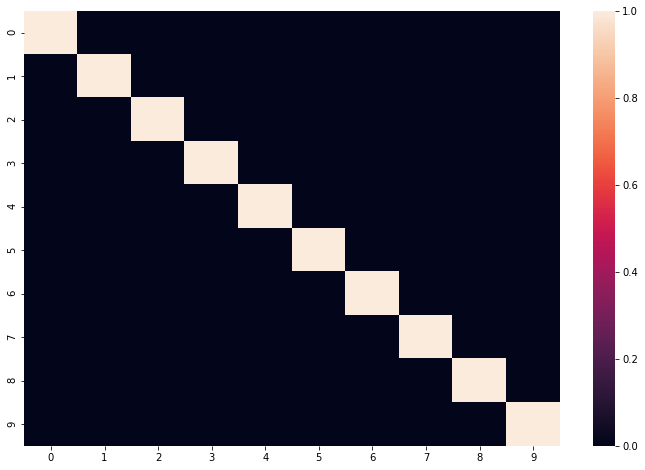

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(reduced2).corr())
plt.show()

In [14]:
reduced2 = pd.DataFrame(reduced2,columns=['desc_bigr_{}'.format(i) for i in range(0,10)])

reduced2.to_pickle('train_nlp_features6.pkl',compression='zip')

# Score Increase. Description Uni + BiGrams

In [20]:
desc_uni = pd.read_pickle('train_nlp_features5.pkl',compression='zip')

In [21]:
desc_uni.head()

,desc_0,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,desc_8,desc_9
0,0.803608,-0.765739,-1.125599,0.656757,0.599217,-0.535874,0.261092,0.993849,0.488599,0.515208
1,-0.026928,-0.170994,0.125098,-0.735124,-0.248549,0.133063,0.042584,0.241774,-0.183617,0.318740
2,1.377258,0.035831,0.515434,-0.367112,0.265219,-0.378904,0.561319,-0.706378,-0.277264,0.319333
3,1.136455,-1.184800,-0.541495,-0.399763,-0.819299,1.051614,-0.313363,-0.182303,-0.530405,0.193798
4,1.418042,-1.448267,-0.884204,-0.203697,0.312748,0.038419,-0.134810,0.342483,-0.501805,0.613536


- Scores with UniGrams.

In [22]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=desc_uni,y=train.deal_probability))

Aggregate score: [0.16149489 0.1572853  0.16064484 0.16115773]


In [23]:
aggregate = desc_uni.join(reduced2)

- Score increased a tiny bit. Just as with titles.

In [31]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=aggregate,y=train.deal_probability))

Aggregate score: [0.16657387 0.16232915 0.16536313 0.16643143]


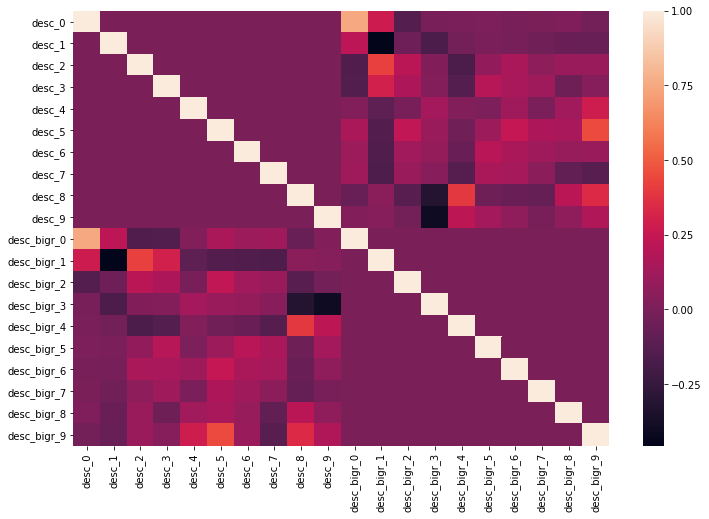

In [32]:
plt.figure(figsize=(12,8))
sns.heatmap(aggregate.corr())
plt.show()

In [33]:
reduce = cross_decomposition.PLSRegression(n_components=10)
reduce.fit(aggregate,train.deal_probability)
print(reduce.score(aggregate,train.deal_probability))

0.16519328123971433


In [34]:
reduced3 = reduce.transform(aggregate)

In [35]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced3,y=train.deal_probability))

Aggregate score: [0.16658564 0.16233271 0.16536627 0.16643276]


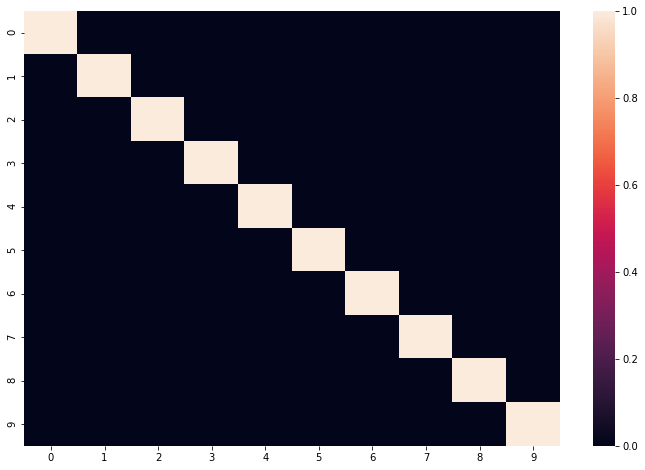

In [36]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(reduced3).corr())
plt.show()

In [37]:
reduced3=pd.DataFrame(reduced3,columns=[np.arange(0,10)])

reduced3.to_pickle('train_nlp_features6.pkl',compression='zip')

# Join Descriptions and Titles

In [39]:
titles = pd.read_pickle('train_nlp_features4.pkl',compression='zip')

In [40]:
titles.shape

(1503424, 10)

In [41]:
titles.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.159448,-0.255352,-0.126976,0.394582,-0.063986,-0.255086,0.130898,0.074473,0.325977,-0.090577
1,0.099028,-0.595640,-0.084234,0.336999,-0.014556,-1.358559,-2.281465,-1.214065,-0.064009,0.405696
2,0.189699,0.076915,0.378001,-0.114864,0.548617,-0.553513,0.485916,0.097064,-0.979922,0.430544
3,1.322911,-2.843348,0.655267,0.664207,-0.445542,0.518189,1.753436,0.173407,-1.754595,0.041796
4,3.074703,3.580497,2.632372,1.796359,3.733847,-1.225274,-0.397432,1.507368,3.851013,-1.635321


In [42]:
print(model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=titles,y=train.deal_probability))

[0.18038783 0.17589027 0.17964832 0.17971962]


In [44]:
aggregate = titles.join(reduced3,rsuffix='descr')

In [45]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=aggregate,y=train.deal_probability))

Aggregate score: [0.2119465  0.2069381  0.2111175  0.21181351]


- OH MY GOD these are the highest scores I've seen so far... These are titles (uni+bigrams) + descriptions (uni+bigrams).

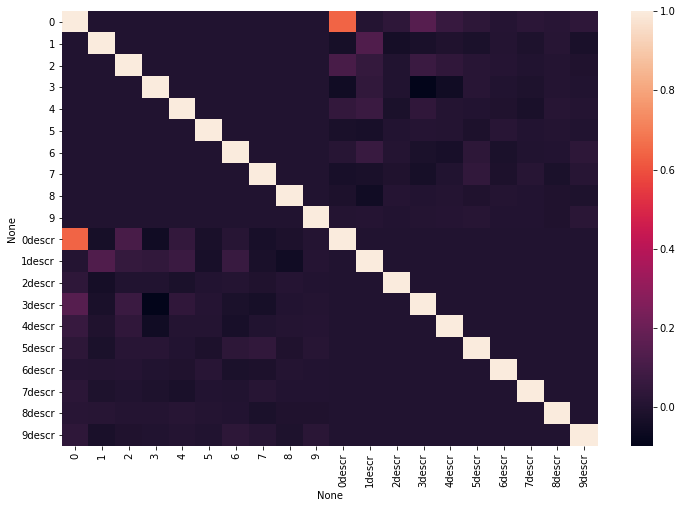

In [46]:
plt.figure(figsize=(12,8))
sns.heatmap(aggregate.corr())
plt.show()

In [47]:
reduce = cross_decomposition.PLSRegression(n_components=10)
reduce.fit(aggregate,train.deal_probability)
print(reduce.score(aggregate,train.deal_probability))

0.2104861172916532


In [48]:
reduced4 = reduce.transform(aggregate)

In [49]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced4,y=train.deal_probability))

Aggregate score: [0.2119555  0.20694358 0.21112967 0.21182824]


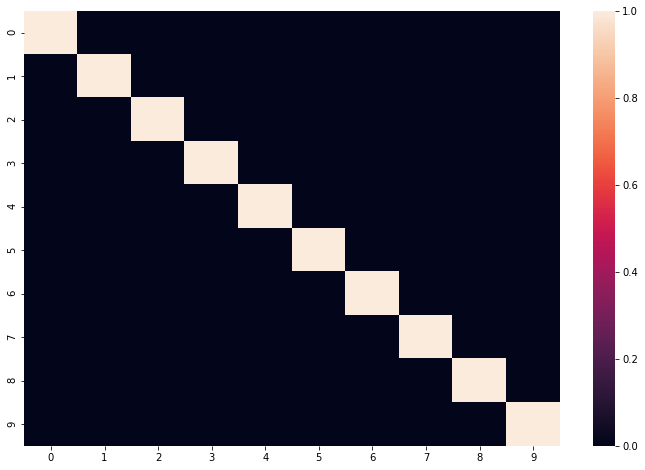

In [50]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(reduced4).corr())
plt.show()

In [51]:
reduced4=pd.DataFrame(reduced4,columns=['title_desc_{}'.format(i) for i in range(0,10)])

reduced4.to_pickle('train_nlp_features7.pkl',compression='zip')

---

In [54]:
model_selection.cross_val_score(
    cv=4,estimator=linear_model.LinearRegression(),
    X=reduced4,y=train.deal_probability,
    scoring=metrics.make_scorer(metrics.mean_squared_error)
)

array([0.05324741, 0.05350178, 0.05332047, 0.05354871])

reduced4 = pd.read_pickle('train_nlp_features7.pkl',compression='zip')